### The BeachNourisher Module

In this notebook we test and show the functionality of the BeachNourisher module within `CASCADE`.

In [1]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.extend(['/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D', '/Users/KatherineAnardeWheels/PycharmProjects/brie', '/Users/KatherineAnardeWheels/PycharmProjects/CASCADE'])
# datadir = "./B3D_Inputs/"  # laptop 
# Path(datadir)
datadir = "/Users/KatherineAnardeWheels/PycharmProjects/CASCADE/B3D_Inputs/"  # laptop

from CASCADE import Cascade
from scripts import CASCADE_plotters as CASCADE_Plt

Here we initialize `CASCADE` with the default wave climate and dune dynamics (average dune growth rate of 0.45), but increase the rate of sea level rise to 0.007 m/yr and simulate only one 500 m `Barrier3D` domain. All other optional modules are turned off (alongshore sediment transport from `BRIE`, community dynamics from `CHOME`, and roadway management). 

The nourishment module requires three input variables at initialization:
- `artificial_max_dune_ele`  # dune rebuilt to this height every nourishment, unless otherwise specified
- `nourishment_interval`  # yrs
- `nourishment_volume` 

CONTINUE EXPLAINING MODEL COMPONENTS SEQUENTIALLY HERE...turn dune migration off once we nourish (we don't allow the dune line to move seaward, as with natural progradation)

In [36]:
# start a model by nourishing one B3D domain at discrete intervals, here we chose to start by nourishing every 15 years; 
# no roadway mgmt, otherwise default conditions except increase sea level rise to 0.005 m/yr
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourishment_intervals",
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
#     community_dynamics_module=False,
    artificial_max_dune_ele=3.7,  # dune rebuilt to this height every nourishment
    nourishment_interval=15,  # yrs
    nourishment_volume=100,  # m^3/m -- 100 should produce about 20 m of shoreline progradation
)


# Loop for 50 years at a 15 year interval, 100 m^3/m and then 50 years at a 20 year interval with 300 m^3/m
Time = time.time()
nt = 50
for time_step in range(nt - 1):
    # Print time step to screen (NOTE: time_index in each model is time_step+1)
    print("\r", "Time Step: ", time_step, end="")
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break
        
# during the CASCADE initialization, the nourishment interval and volume is specified individually for each 
# barrier3d alongshore cell; so to update these values, we need to specify which barrier3d cell we want to modify
# (here, we only have one cell)
cascade.nourishment_interval[iB3D] = 20  # increase to 20 years
cascade.nourishment_volume[iB3D] = 300  # increase to 300 m^3/m

for time_step in range(nt):
    # Print time step to screen (NOTE: time_index in each model is time_step+1)
    print("\r", "Time Step: ", time_step, end="")
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break

 Time Step:  49

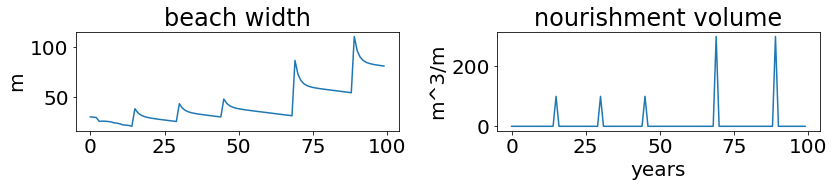

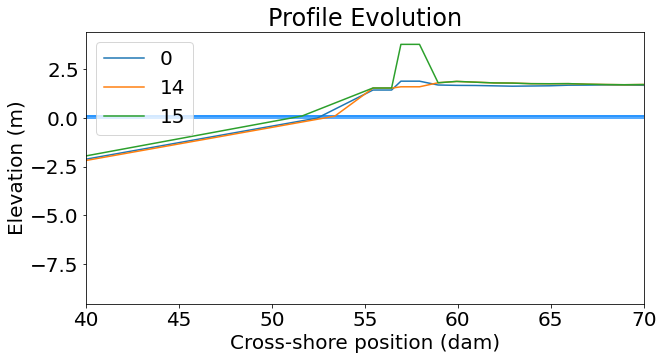

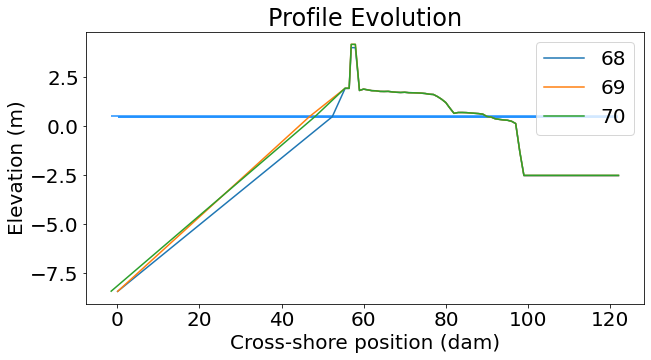

In [42]:
fig=plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(cascade.nourishments[0].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(1,2,2)
plt.plot(cascade.nourishments[0]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")
plt.xlabel("years")
fig.tight_layout()

time_step = [0,14,15]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
fig.set_xlim([40,70])
# fig.set_ylim([-1,3])

time_step = [68, 69, 70]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
# fig.set_xlim([50,60])
# fig.set_ylim([-1,3])

Remaining tests for Katherine: check different rates of sea level rise, add AST (want planform view for this), turn dune migration back on after <10 m beach width

array([ 30.        ,  29.74659597,  29.32284509,  25.48119951,
        25.77495223,  25.68338767,  25.39140459,  25.00600778,
        24.06597632,  23.75203082,  23.04061243,  21.97600714,
        21.74228307,  21.40705973,  20.57767042,  38.19044842,
        34.17497587,  31.93090975,  30.57486675,  29.6822812 ,
        29.03415675,  28.51660256,  28.06872976,  27.65838283,
        27.26777561,  26.88824121,  26.51434306,  26.14373821,
        25.77466509,  25.40625157,  43.19262764,  38.93006335,
        36.57517728,  35.17015283,  34.25462304,  33.595967  ,
        33.07266518,  32.62128433,  32.20868207,  31.81641256,
        31.43509006,  31.05938047,  30.6866981 ,  30.31568244,
        29.94568617,  47.88601825,  43.53595774,  41.15322649,
        39.73945298,  38.8219932 ,  38.16287293,  37.64012126,
        37.18909201,  36.77596598,  36.38341803,  36.00118224,
        35.62446347,  35.2505001 ,  34.87786521,  34.5059101 ,
        34.13424248,  33.76247728,  33.39096752,  33.01